In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from misc.viz import plot2d
from model.setup import find_id_for_P, load_P_pred
from model.networks.linear import CalculatedP
from misc.viz import plot2d
from data.generate_2d import sine1d, sine2d, flower, mnist
from data.generate_data import datasets

from misc.utils_results import plot_data, assert_unique, pivot, plot_pivot, add_df_map_new, assert_columns_same, get_and_check_Ps, plot_seeds_and_Ps, rename_net
from misc.wandb import exceptions, new_runs

## WandB

In [12]:
api = wandb.Api()
runs = api.runs('eliasdubbeldam/symlie')

results_df_old = pd.read_pickle('../logs/store/results_df.pkl')
# results_df_old = pd.DataFrame(columns=results_df_old.columns)
runs_selected = exceptions(runs, results_df_old)
print(len(runs_selected))
results_df = new_runs(runs_selected)

results_df_new = pd.concat([results_df_old, results_df]).reset_index(drop=True)
assert_unique(results_df_new)
results_df_new.to_pickle(os.path.join('../logs/store/results_df.pkl'))

15


Retreiving wandb 4lhc56pb: 100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


In [13]:
df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

(256, 41)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val', 'train',
       'y_low', 'device', 'logger', 'n_test', 'run_id', 'y_high', 'log_dir',
       'n_train', 'predict', 'version', 'data_dir', 'eps_mult', 'n_splits',
       'criterion', 'do_return', 'earlystop', 'grid_size', 'noise_std',
       'only_flip', 'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'generate_data', 'model_summary', 'args_processed', 'do_return_model',
       'transform_kwargs', 'persistent_workers', 'run_name', 'test_loss',
       'space_length'],
      dtype='object')


lr               net   bias  name seed                    tags  test  \
0  0.0001  Predict-TrainedP  False  None    3  ['sine2d-rot-predict']  True   
1  0.0001     Predict-NoneP  False  None    3  ['sine2d-rot-predict']  True   
2  0.0001  Predict-TrainedP  False  None    2  ['sine2d-rot-predict']  True   
3  0.0001     Predict-NoneP  False  None    2  ['sine2d-rot-predict']  True   
4  0.0010  Predict-TrainedP  False  None    3  ['sine2d-rot-predict']  True   

  n_val train  y_low  ... num_workers generate_data model_summary  \
0  1000  True    1.0  ...          18         False         False   
1  1000  True    1.0  ...          18         False         False   
2  1000  True    1.0  ...          18         False         False   
3  1000  True    1.0  ...          18         False         False   
4  1000  True    1.0  ...          18         False         False   

  args_processed  do_return_model  \
0           True            False   
1           True            False   
2           True            False   
3           True            False   
4           True            False   

                                 transform_kwargs persistent_workers  \
0  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}               True   
1  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}               True   
2  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}               True   
3  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}               True   
4  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}               True   

               run_name test_loss space_length  
0     virtuous-fuse-614  0.001333          NaN  
1   sparkling-paper-613  0.002179          NaN  
2     crimson-peony-611  0.001435          NaN  
3  glowing-dumpling-612  0.002166          NaN  
4    red-springroll-610  0.001172          NaN  

[5 rows x 41 columns]

In [19]:
df_map_columns = ['run_id', 'tags', 'data_kwargs', 'transform_kwargs', 'seed', 'data_dir']

## Sine1d

In [4]:
d = df[df['tags'].astype(str).str.contains('sine1d')]
d = d.drop_duplicates(subset=['lr', 'n_train', 'seed']) # TODO: why is this necessary?
d.shape

(45, 41)

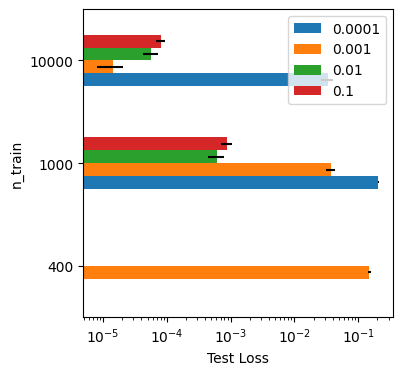

In [5]:
plot_pivot(d, columns = ['n_train', 'lr'], logx=True)

In [7]:
df_map_new = d[(d['n_train'] == 10_000) & (d['lr'] == 1e-3)][df_map_columns]
map_kwargs = assert_columns_same(df_map_new, ['data_kwargs', 'transform_kwargs', 'data_dir'])
df_map = add_df_map_new(df_map_new)
df_map_new

run_id        tags                                        data_kwargs  \
163  wqmfolq3  ['sine1d']  {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...   
170  9g2e5b7x  ['sine1d']  {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...   
179  vgc5pdak  ['sine1d']  {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...   
189  ihexez6d  ['sine1d']  {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...   
197  xppfwtlj  ['sine1d']  {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...   

                                   transform_kwargs seed        data_dir  
163  {'eps_mult': [0, 0, 1, 0], 'only_flip': False}    5  ../data/sine1d  
170  {'eps_mult': [0, 0, 1, 0], 'only_flip': False}    4  ../data/sine1d  
179  {'eps_mult': [0, 0, 1, 0], 'only_flip': False}    3  ../data/sine1d  
189  {'eps_mult': [0, 0, 1, 0], 'only_flip': False}    2  ../data/sine1d  
197  {'eps_mult': [0, 0, 1, 0], 'only_flip': False}    1  ../data/sine1d

Found run_id xppfwtlj
Found run_id ihexez6d
Found run_id vgc5pdak
Found run_id 9g2e5b7x
Found run_id wqmfolq3


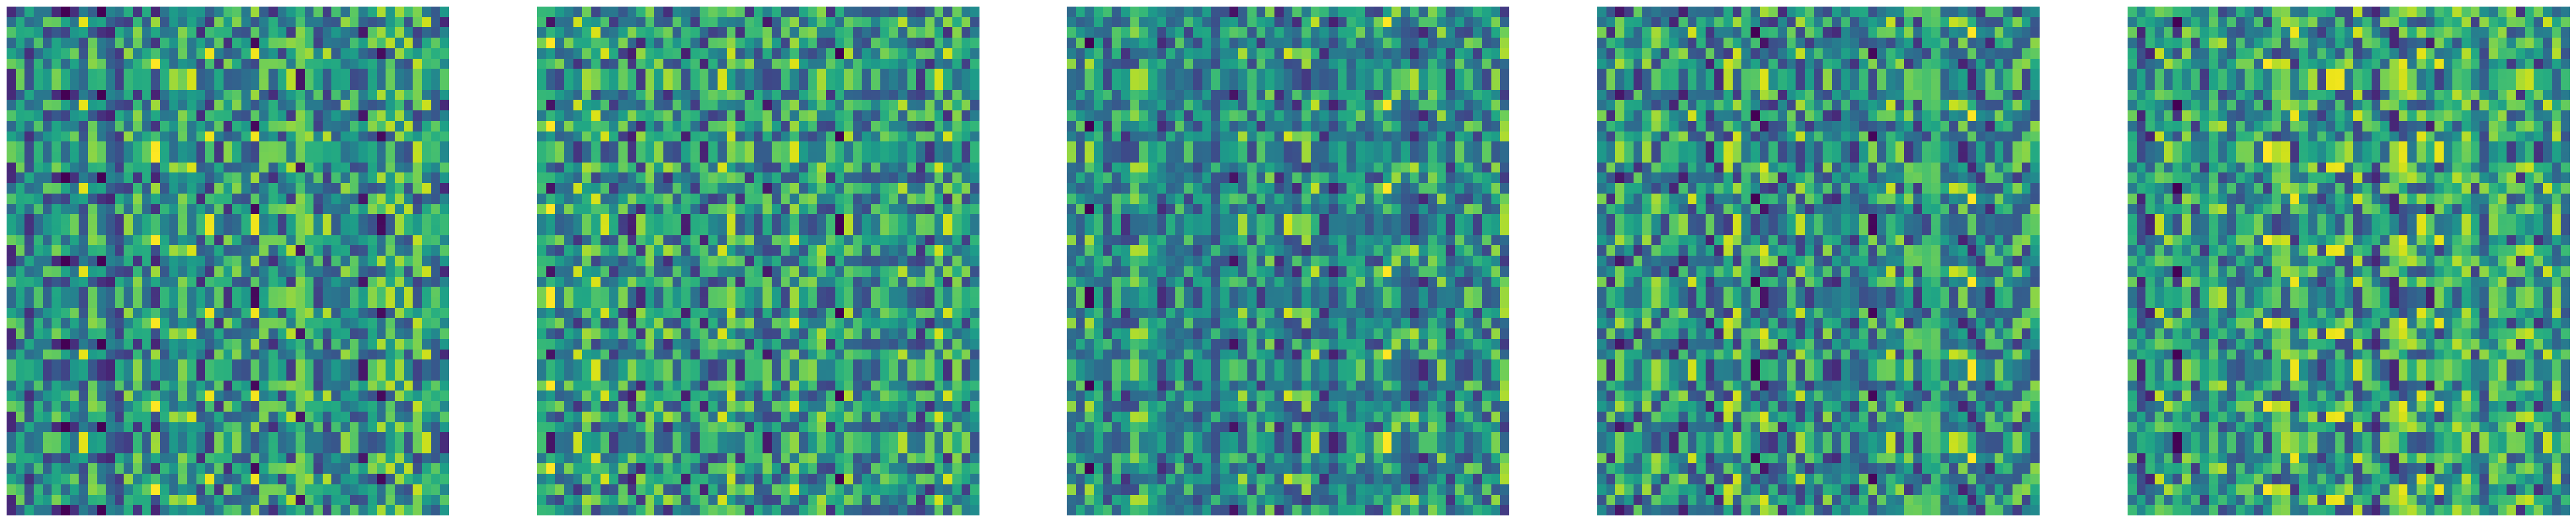

In [8]:
Ps = get_and_check_Ps([1, 2, 3, 4, 5], map_kwargs)
plot2d(Ps, l = 10, max_grid = None)

## Sine1d-predict

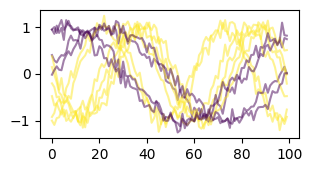

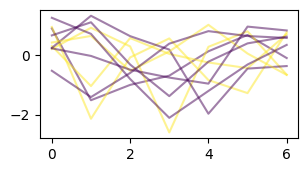

In [9]:
plot_data(datasets['sine1d'], N_plot=10, l = 1/3)

In [10]:
d = df[df['tags'].astype(str).str.contains('sine1d-predict')].reset_index(drop=True)
assert_columns_same(d, ['data_kwargs', 'transform_kwargs'], datasets['sine1d'])

d_pivot = pivot(d, columns = ['net'])
d_pivot = rename_net(d_pivot)

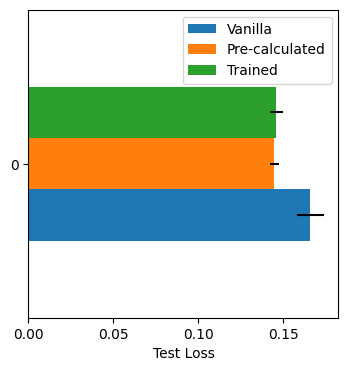

In [11]:
plot_pivot(d_pivot=d_pivot)

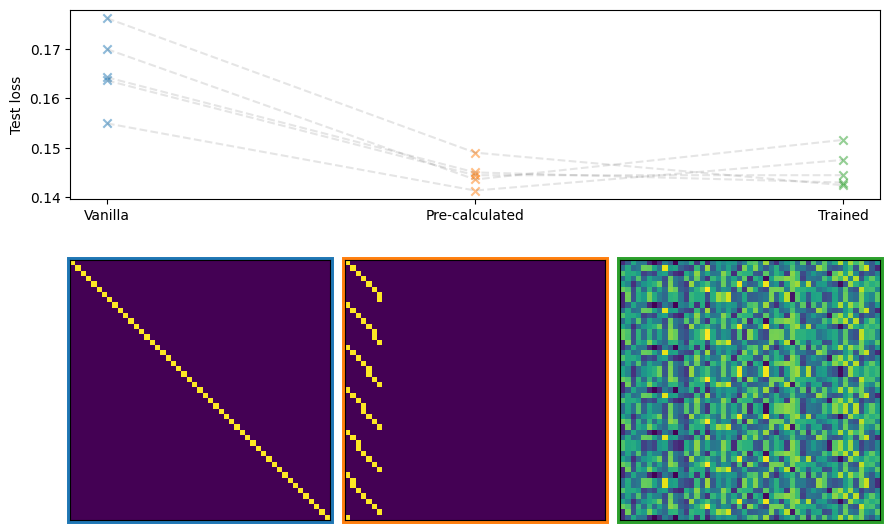

In [12]:


calculated_Ps = {k: v for k, v in CalculatedP(size=np.prod(map_kwargs['data_kwargs']['grid_size'])).transform_funcs.items()}
P_plots = {
    'Vanilla': calculated_Ps['none'],
    'Pre-calculated': calculated_Ps['space_translation'],
    'Trained': Ps[0]
}
plot_seeds_and_Ps(d_pivot, P_plots)

## Sine2d

In [13]:
d = df[df['tags'].astype(str).str.contains("'sine2d'")].reset_index(drop=True)
d

lr     net   bias  name seed        tags  test n_val train  y_low  ...  \
0  0.001  TrainP  False  None    5  ['sine2d']  True  1000  True    1.0  ...   
1  0.001  TrainP  False  None    4  ['sine2d']  True  1000  True    1.0  ...   
2  0.001  TrainP  False  None    3  ['sine2d']  True  1000  True    1.0  ...   
3  0.001  TrainP  False  None    1  ['sine2d']  True  1000  True    1.0  ...   
4  0.001  TrainP  False  None    2  ['sine2d']  True  1000  True    1.0  ...   

  num_workers generate_data model_summary args_processed  do_return_model  \
0          18         False         False           True            False   
1          18         False         False           True            False   
2          18         False         False           True            False   
3          18         False         False           True            False   
4          18         False         False           True            False   

                                 transform_kwargs persistent_workers  \
0  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}               True   
1  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}               True   
2  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}               True   
3  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}               True   
4  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}               True   

              run_name test_loss space_length  
0  lemon-waterfall-278  0.013377          NaN  
1     divine-blaze-277  0.013029          NaN  
2     swift-deluge-276  0.013021          NaN  
3    fallen-vortex-275  0.013372          NaN  
4      desert-star-274  0.013138          NaN  

[5 rows x 41 columns]

In [14]:
df_map_new = d[df_map_columns]
df_map = add_df_map_new(df_map_new)
map_kwargs = assert_columns_same(df_map_new, ['data_kwargs', 'transform_kwargs', 'data_dir'])
df_map_new

run_id        tags                                        data_kwargs  \
0  42b5jtma  ['sine2d']  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   
1  mvpwp51a  ['sine2d']  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   
2  iugjxsv4  ['sine2d']  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   
3  d8e2f8th  ['sine2d']  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   
4  pl22gfan  ['sine2d']  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   

                                 transform_kwargs seed        data_dir  
0  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    5  ../data/sine2d  
1  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    4  ../data/sine2d  
2  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    3  ../data/sine2d  
3  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    1  ../data/sine2d  
4  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    2  ../data/sine2d

Found run_id 42b5jtma
Found run_id mvpwp51a
Found run_id iugjxsv4
Found run_id d8e2f8th
Found run_id pl22gfan


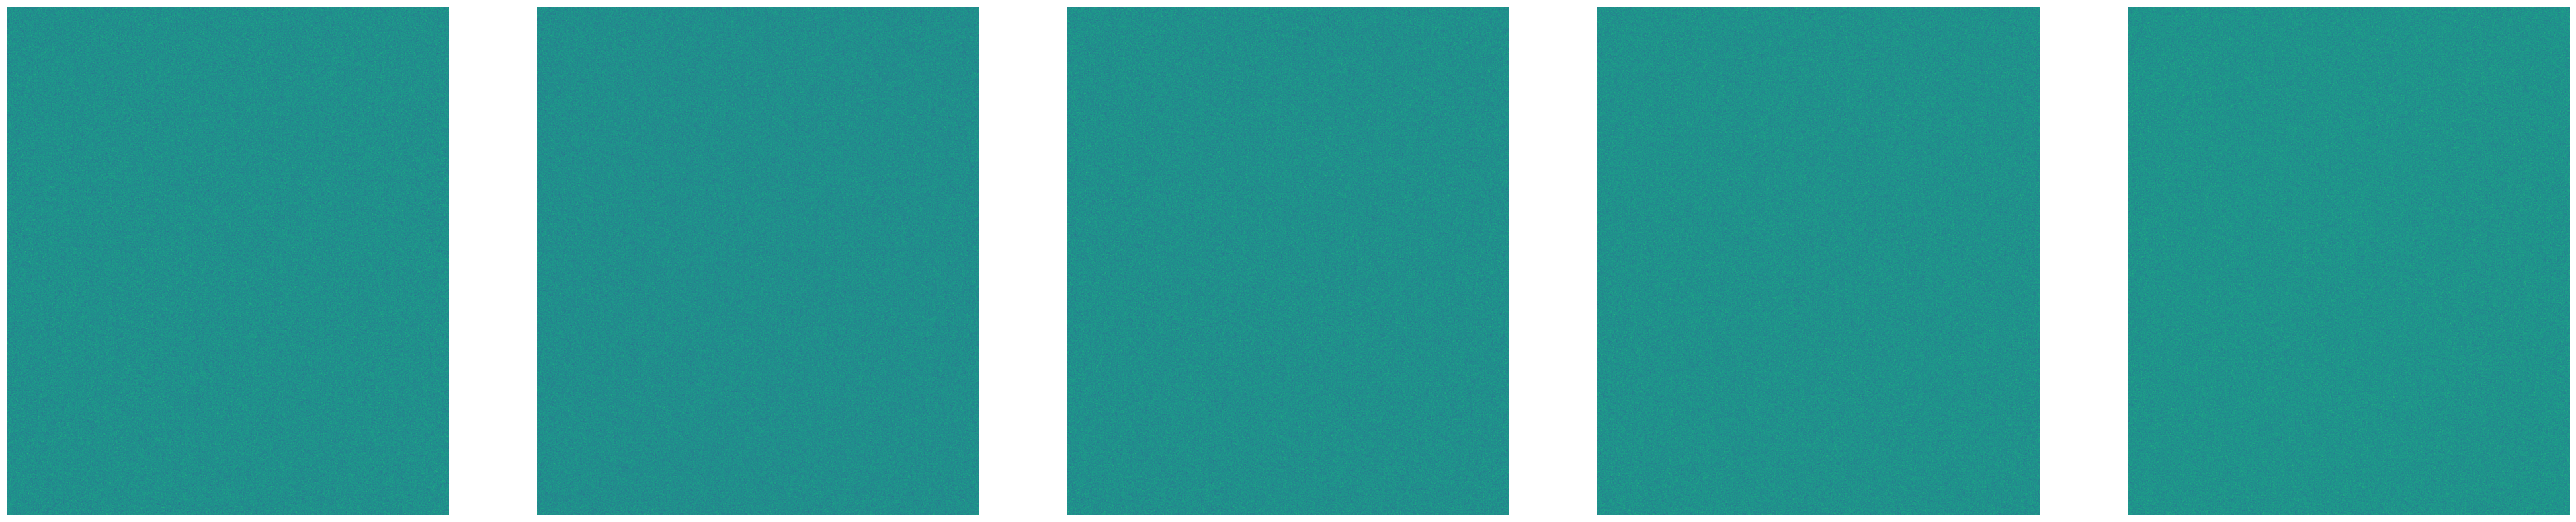

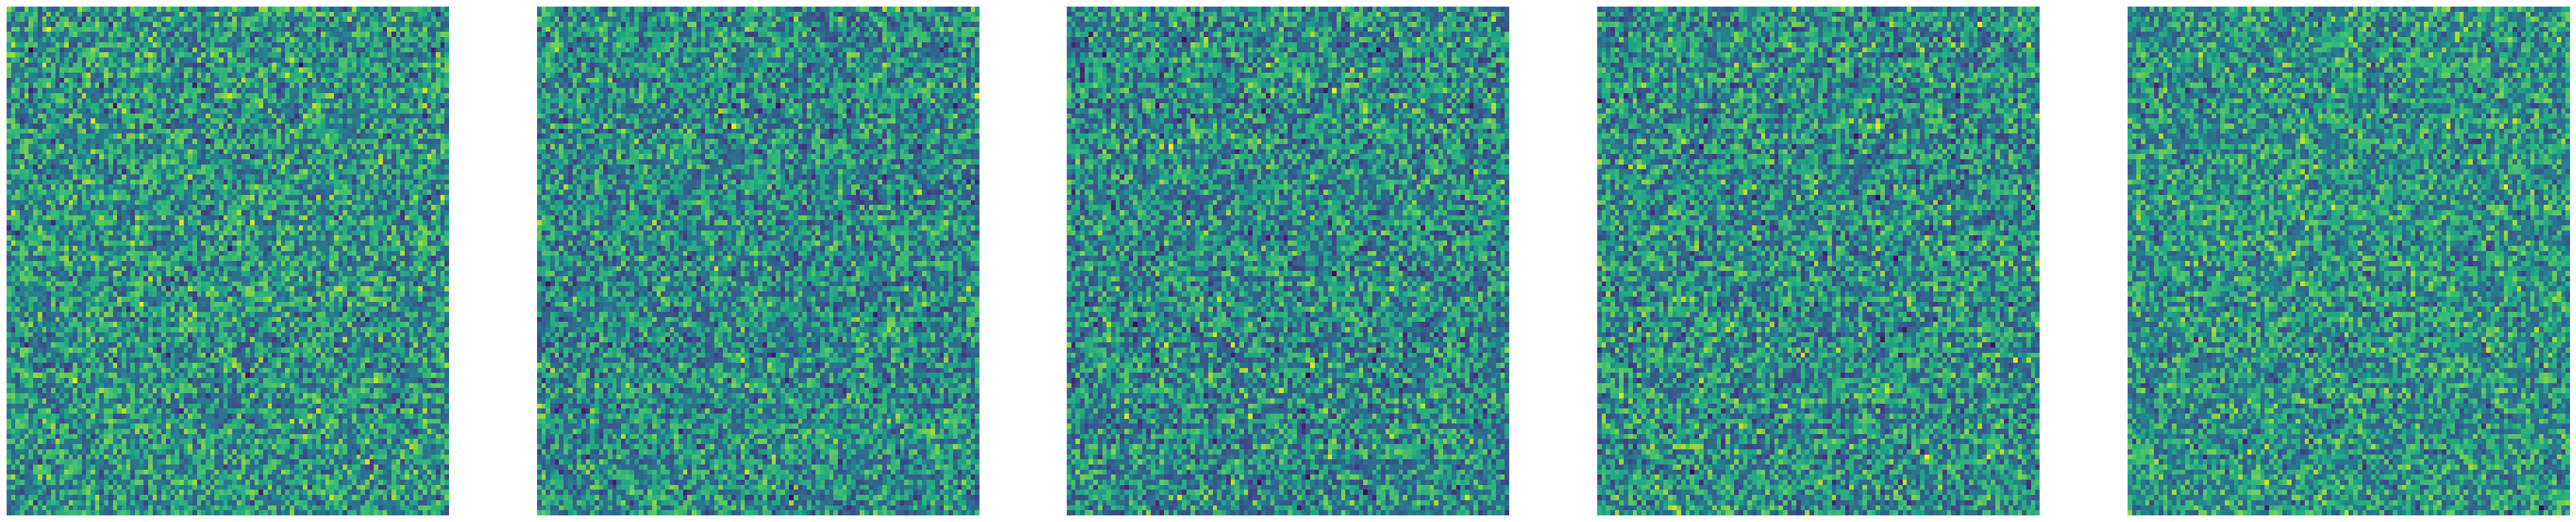

In [15]:
Ps = get_and_check_Ps(d['seed'].unique(), map_kwargs)
plot2d(Ps, l = 10)
plot2d(Ps, l = 10, max_grid = 100)

## Sine2d predict

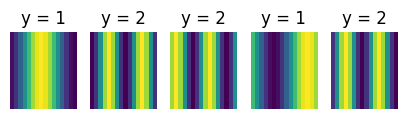

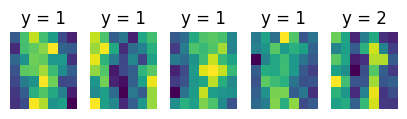

In [16]:
plot_data(datasets['sine2d'], N_plot=5)

In [17]:
d = df[df['tags'].astype(str).str.contains('sine2d-predict')].reset_index(drop=True)
map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs'], datasets['sine2d'])
d

lr               net   bias  name seed                tags  test n_val  \
0  0.001     Predict-NoneP  False  None    5  ['sine2d-predict']  True  1000   
1  0.001     Predict-NoneP  False  None    4  ['sine2d-predict']  True  1000   
2  0.001     Predict-NoneP  False  None    3  ['sine2d-predict']  True  1000   
3  0.001     Predict-NoneP  False  None    2  ['sine2d-predict']  True  1000   
4  0.001     Predict-NoneP  False  None    1  ['sine2d-predict']  True  1000   
5  0.001  Predict-TrainedP  False  None    3  ['sine2d-predict']  True  1000   
6  0.001  Predict-TrainedP  False  None    4  ['sine2d-predict']  True  1000   
7  0.001  Predict-TrainedP  False  None    5  ['sine2d-predict']  True  1000   
8  0.001  Predict-TrainedP  False  None    2  ['sine2d-predict']  True  1000   
9  0.001  Predict-TrainedP  False  None    1  ['sine2d-predict']  True  1000   

  train  y_low  ... num_workers generate_data model_summary args_processed  \
0  True    1.0  ...           7         False         False           True   
1  True    1.0  ...           7         False         False           True   
2  True    1.0  ...           7         False         False           True   
3  True    1.0  ...           7         False         False           True   
4  True    1.0  ...           7         False         False           True   
5  True    1.0  ...          18         False         False           True   
6  True    1.0  ...          18         False         False           True   
7  True    1.0  ...          18         False         False           True   
8  True    1.0  ...          18         False         False           True   
9  True    1.0  ...          18         False         False           True   

   do_return_model                                transform_kwargs  \
0            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
1            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
2            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
3            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
4            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
5            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
6            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
7            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
8            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
9            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   

  persistent_workers                run_name test_loss space_length  
0               True          drawn-pond-290  0.039015          NaN  
1               True      leafy-capybara-289  0.042676          NaN  
2               True         proud-water-288  0.038449          NaN  
3               True       smooth-cosmos-287  0.054436          NaN  
4               True   graceful-serenity-286  0.040034          NaN  
5               True         woven-cloud-283  0.030914          NaN  
6               True        summer-water-282  0.030942          NaN  
7               True     apricot-terrain-281  0.029362          NaN  
8               True   curious-armadillo-280  0.031029          NaN  
9               True  radiant-wildflower-279  0.029041          NaN  

[10 rows x 41 columns]

In [18]:
d_pivot = pivot(d, columns = ['net'])
d_pivot = rename_net(d_pivot)
d_pivot

test_loss          
net    Vanilla   Trained
seed                    
1     0.040034  0.029041
2     0.054436  0.031029
3     0.038449  0.030914
4     0.042676  0.030942
5     0.039015  0.029362

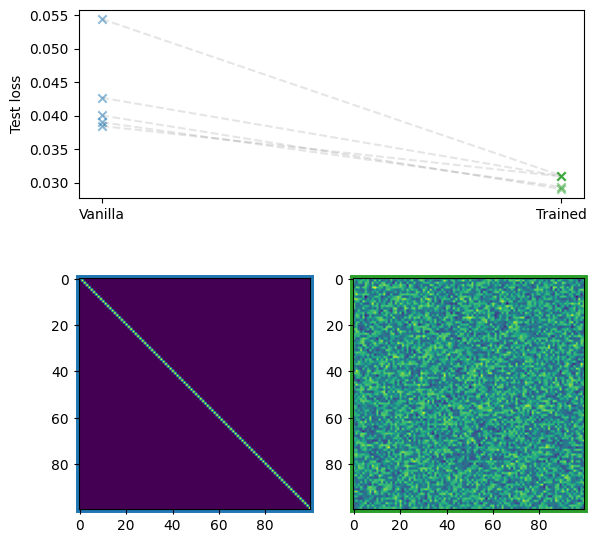

In [19]:
calculated_Ps = {k: v for k, v in CalculatedP(size=np.prod(map_kwargs['data_kwargs']['grid_size'])).transform_funcs.items()}
P_plots = {
    'Vanilla': calculated_Ps['none'][:100, :100],
    'Trained': Ps[0][:100, :100]
}
plot_seeds_and_Ps(d_pivot, P_plots, disable_ticks=True)

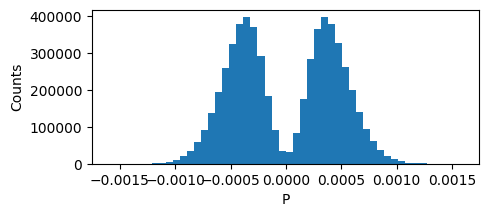

In [20]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.hist( Ps[0].flatten().numpy(), bins=50 )
ax.set_xlabel('P')
ax.set_ylabel('Counts')
plt.show()

## Sine2d-rot

In [21]:
d = df[df['tags'].astype(str).str.contains("'sine2d-rot'")].reset_index(drop=True)
map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])

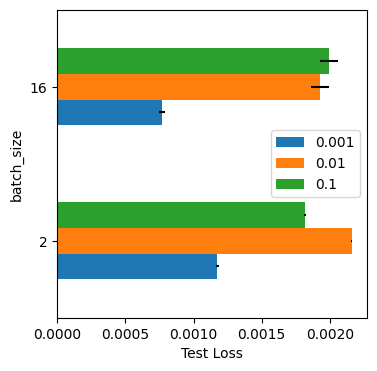

In [22]:
plot_pivot(d, columns = ['batch_size', 'lr'])

In [23]:
df_map_new = d[(d['batch_size'] == 16) & (d['lr'] == 0.001)][df_map_columns]
df_map = add_df_map_new(df_map_new)
df_map_new

run_id            tags  \
0  j3ek4otr  ['sine2d-rot']   
1  vgsewkvn  ['sine2d-rot']   
2  bimu03x8  ['sine2d-rot']   

                                         data_kwargs  \
0  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   
1  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   
2  {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...   

                                 transform_kwargs seed        data_dir  
0  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}    3  ../data/sine2d  
1  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}    2  ../data/sine2d  
2  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}    1  ../data/sine2d

Found run_id j3ek4otr
Found run_id vgsewkvn
Found run_id bimu03x8


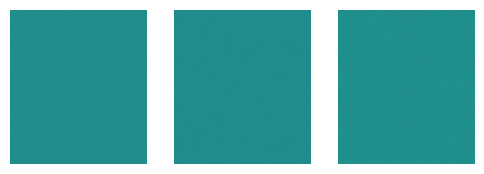

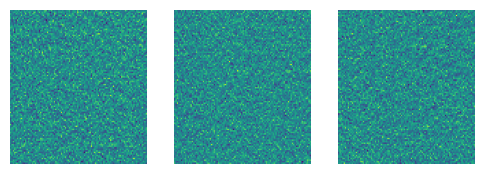

In [24]:
Ps = get_and_check_Ps(df_map_new['seed'].unique(), map_kwargs)
plot2d(Ps, l = 2)
plot2d(Ps, l = 2, max_grid = 100)

## Sine2d-rot-predict

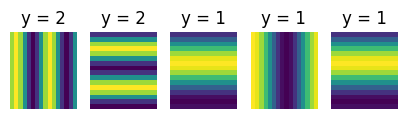

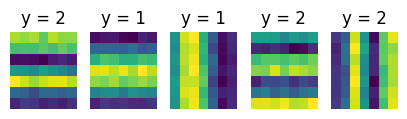

In [25]:
plot_data(datasets['sine2d-rot'], N_plot=5)

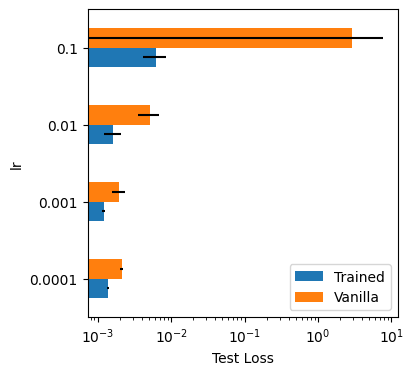

In [26]:
d = df[df['tags'].astype(str).str.contains('sine2d-rot-predict')].reset_index(drop=True)
assert_columns_same(d, ['data_kwargs', 'transform_kwargs'], datasets['sine2d-rot'])

d_pivot = pivot(d, columns = ['lr', 'net'])
d_pivot = rename_net(d_pivot, level = 2)
plot_pivot(d_pivot=d_pivot, logx=True)

## Flower

In [15]:
d.groupby(['batch_size', 'lr']).size()

batch_size  lr   
2           0.001    3
            0.010    2
            0.100    3
16          0.001    3
            0.010    3
            0.100    1
dtype: int64

In [16]:
d = df[df['tags'].astype(str).str.contains("'flower'")].reset_index(drop=True)
map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])

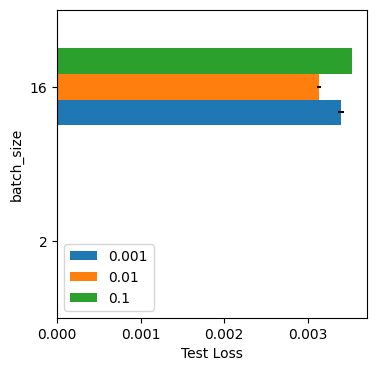

In [17]:
plot_pivot(d, columns = ['batch_size', 'lr'])

In [21]:
df_map_new = d[(d['batch_size'] == 16) & (d['lr'] == 0.01)][df_map_columns]
df_map = add_df_map_new(df_map_new)
df_map_new

run_id        tags                                        data_kwargs  \
8   zh3z27b6  ['flower']  {'y_low': 2, 'y_high': 7, 'grid_size': [10, 10...   
9   pibpnfoo  ['flower']  {'y_low': 2, 'y_high': 7, 'grid_size': [10, 10...   
10  2sf6rmgf  ['flower']  {'y_low': 2, 'y_high': 7, 'grid_size': [10, 10...   

                                  transform_kwargs seed        data_dir  
8   {'eps_mult': [0, 1, 1, 1], 'only_flip': False}    1  ../data/flower  
9   {'eps_mult': [0, 1, 1, 1], 'only_flip': False}    3  ../data/flower  
10  {'eps_mult': [0, 1, 1, 1], 'only_flip': False}    2  ../data/flower

In [22]:
Ps = get_and_check_Ps(df_map_new['seed'].unique(), map_kwargs)
plot2d(Ps, l = 2)
plot2d(Ps, l = 2, max_grid = 100)

Found run_id zh3z27b6


FileNotFoundError: [Errno 2] No such file or directory: '../logs/store/P/zh3z27b6.npy'

## MNIST eps_mult = 0. 0. 1. 1.

In [27]:
d = df[(df['tags'].astype(str).str.contains("'mnist'"))].reset_index(drop=True) 
d

lr     net   bias  name seed                tags  test n_val train  \
0  0.01  TrainP  False  None    1  ['long2', 'mnist']  True  1000  True   
1  0.01  TrainP  False  None    3  ['long2', 'mnist']  True  1000  True   
2  0.01  TrainP  False  None    2  ['long2', 'mnist']  True  1000  True   

   y_low  ... num_workers generate_data model_summary args_processed  \
0    NaN  ...          18         False         False           True   
1    NaN  ...          18         False         False           True   
2    NaN  ...          18         False         False           True   

   do_return_model                                transform_kwargs  \
0            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
1            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   
2            False  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}   

  persistent_workers               run_name test_loss space_length  
0               True    cosmic-universe-419  0.000709          NaN  
1               True   divine-spaceship-418  0.000711          NaN  
2               True  ancient-resonance-417  0.000752          NaN  

[3 rows x 41 columns]

In [28]:
df_map_new = d[df_map_columns]
map_kwargs = assert_columns_same(df_map_new, ['data_kwargs', 'transform_kwargs', 'data_dir'])
df_map = add_df_map_new(df_map_new)
df_map_new

run_id                tags                            data_kwargs  \
0  i1dkddgf  ['long2', 'mnist']  {'grid_size': [7, 7], 'noise_std': 0}   
1  q3ic50qj  ['long2', 'mnist']  {'grid_size': [7, 7], 'noise_std': 0}   
2  up6r9ere  ['long2', 'mnist']  {'grid_size': [7, 7], 'noise_std': 0}   

                                 transform_kwargs seed       data_dir  
0  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    1  ../data/MNIST  
1  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    3  ../data/MNIST  
2  {'eps_mult': [0, 0, 1, 1], 'only_flip': False}    2  ../data/MNIST

Found run_id i1dkddgf
Found run_id q3ic50qj
Found run_id up6r9ere


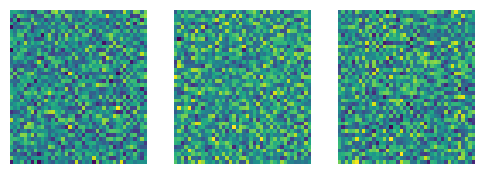

In [29]:
Ps = get_and_check_Ps(df_map_new['seed'].unique(), map_kwargs)
plot2d(Ps, l = 2, max_grid = 40)

## MNIST predict eps_mult = 0. 0. 1. 1.

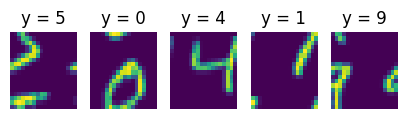

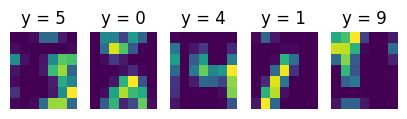

In [30]:
plot_data(datasets['mnist'], N_plot=5)

In [31]:
d = df[df['tags'].astype(str).str.contains('mnist-predict') & (df['tags'].astype(str).str.contains('long22'))].reset_index(drop=True)
assert_columns_same(d, ['data_kwargs', 'transform_kwargs'], datasets['mnist'])

d_pivot = pivot(d, columns = ['lr', 'batch_size', 'net'])
d_pivot = rename_net(d_pivot, level = 3)
d_pivot

test_loss                                                    \
lr             0.001                                                     
batch_size        4                   8                   16             
net          Vanilla   Trained   Vanilla   Trained   Vanilla   Trained   
seed                                                                     
1           1.311324  2.233778  1.269559  2.231893  1.253524  2.233016   
2           1.169947  2.170547  1.159626  2.169964  1.188426  2.168425   
3           1.220453  2.175587  1.218508  2.173012  1.301518  2.171268   

                                                                        
lr             0.010                                                    
batch_size        4                   8                   16            
net          Vanilla   Trained   Vanilla   Trained   Vanilla   Trained  
seed                                                                    
1           1.531502  1.471081  1.348231  1.467352  1.337135  1.498045  
2           1.653219  1.548011  1.563732  1.639064  1.350304  1.692156  
3           1.711165  1.634471  1.492008  1.701429  1.205859  1.733363

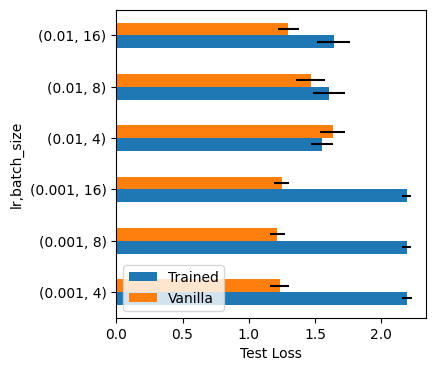

In [32]:
plot_pivot(d_pivot=d_pivot, logx=False, legend_loc = 'lower left')